# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

In [1]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-06-13 06:55:09--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  19.2MB/s    in 4.4s    

2020-06-13 06:55:14 (16.9 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [2]:
!unzip /content/apple2orange.zip

Archive:  /content/apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2orange/trainA/n07740461_2918.jpg  
  inflating: apple2orange/trainA/n07740461_1213.jpg  
  inflating: apple2orange/trainA/n07740461_2476.jpg  
  inflating: apple2orange/trainA/n07740461_13596.jpg  
  inflating: apple2orange/trainA/n07740461_4093.jpg  
  inflating: apple2orange/trainA/n07740461_14738.jpg  
  inflating: apple2orange/trainA/n07740461_6477.jpg  
  inflating: apple2orange/trainA/n07740461_11356.jpg  
  inflating: apple2orange/trainA/n07740461_7594.jpg  
  inflating: apple2orange/trainA/n07740461_5119.jpg  
  inflating: apple2orange/trainA/n077

In [0]:
!mkdir "weights"

In [0]:
!mkdir "optim"

In [0]:
!touch "history.txt"

Импорт модулей

In [0]:
import torch
import numpy as np
import PIL
import os
import sys

In [0]:
from skimage import io, transform

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, utils
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import itertools

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from IPython.display import clear_output

In [0]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
DATA_MODES = ['test', 'train']
# работаем на видеокарте
DEVICE = torch.device("cuda")

Преобразование картинок

In [0]:
# Для train
augmentation_train = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                 transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

# Для test
augmentation_test = transforms.Compose (
                          [
                              transforms.Resize((256, 256)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])

In [0]:
class ModelDataset(Dataset):

  def __init__(self, root, mode, augmentation=None):
    super().__init__()
    self.files_A = sorted(list(Path('{}/{}A'.format(root, mode)).rglob('*.jpg')))
    self.files_B = sorted(list(Path('{}/{}B'.format(root, mode)).rglob('*.jpg')))
    self.mode = mode
    self.augmentation = augmentation

    if self.mode not in DATA_MODES:
      print ("{} is not correct".format(self.mode))
      raise NameError
    
  def load(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    A = self.load(self.files_A[index % len(self.files_A)])
    A = np.array(np.array(A) / 255, dtype='float32')
    A = self.augmentation(Image.fromarray((A*255).astype('uint8')))

    B = self.load(self.files_B[index % len(self.files_B)])
    B = np.array(np.array(B) / 255, dtype='float32')
    B = self.augmentation(Image.fromarray((B*255).astype('uint8')))

    return {'A': A, 'B': B}

  def __len__(self):
    return max(len(self.files_A), len(self.files_B))

  def len_A(self):
    return len(self.files_A)

  def len_B(self):
    return len(self.files_B)

  def get_name(self, index, typ):
    if typ == 'A':
      return self.files_A[index % len(self.files_A)].name
    else:
      return self.files_B[index % len(self.files_B)].name

In [0]:
train_dataset = ModelDataset('/content/apple2orange', mode='train', augmentation=augmentation_train)

Просмотрим данные

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


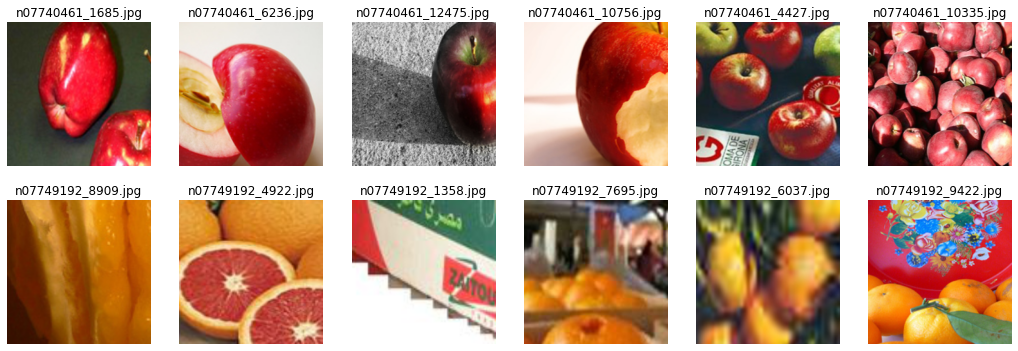

In [14]:
plt.figure(figsize=(18, 6))

for i in range(6):
    ax1 = plt.subplot(2, 6, i+1)
    random1 = int(np.random.uniform(0, train_dataset.len_A()))
    ax1.set_title(train_dataset.get_name(random1, 'A'))
    plt.axis("off")
    imshow(train_dataset[random1]['A'].data.cpu())

    ax2 = plt.subplot(2, 6, i+7)
    random2 = int(np.random.uniform(0, train_dataset.len_B()))
    plt.axis("off")
    ax2.set_title(train_dataset.get_name(random2, 'B'))
    imshow(train_dataset[random2]['B'].data.cpu())

plt.show()

Модели

In [0]:
class ResnetGenerator(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        #downsampling
        self.downsample1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Resnet Block
        self.resnet_block1 = ResnetBlock(256)
        self.resnet_block2 = ResnetBlock(256)
        self.resnet_block3 = ResnetBlock(256)
        self.resnet_block4 = ResnetBlock(256)
        self.resnet_block5 = ResnetBlock(256)
        self.resnet_block6 = ResnetBlock(256)
        self.resnet_block7 = ResnetBlock(256)
        self.resnet_block8 = ResnetBlock(256)
        self.resnet_block9 = ResnetBlock(256)


        # upsample
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7),
            nn.Tanh()
        )
  

    def forward(self, x):

        x = self.layer1(x)
        x = self.downsample1(x)
    
        x = self.resnet_block1(x)
        x = self.resnet_block2(x)
        x = self.resnet_block3(x)
        x = self.resnet_block4(x)
        x = self.resnet_block5(x)
        x = self.resnet_block6(x)
        x = self.resnet_block7(x)
        x = self.resnet_block8(x)
        x = self.resnet_block9(x)

        x = self.upsample(x)
        x = self.layer2(x) 
        return x

In [0]:
class ResnetBlock(nn.Module):

    def __init__(self, input_ch):
        super().__init__()
    
        self.res_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(input_ch, input_ch, kernel_size=3),
            nn.InstanceNorm2d(input_ch),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(input_ch, input_ch, kernel_size=3),
            nn.InstanceNorm2d(input_ch)
        )
  
    def forward(self, x):
        return x + self.res_block(x)

In [0]:
class PixelDiscriminant(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
          nn.InstanceNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
          nn.InstanceNorm2d(256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
          nn.InstanceNorm2d(512),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        x = self.layer(x)
        return x

Обучение

In [0]:
# Размер батча
batch_size = 1

# Количество эпох для обучения
num_epochs = 50

In [0]:
def train (model_gen_AtoB, model_gen_BtoA, model_discr_A, model_discr_B, \
          optimizer_G, optimizer_D_A, optimizer_D_B, train_files, epochs=2, batch_size=10):
  
    criterion_GAN = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()
    # Для картин доп. лосс [https://arxiv.org/pdf/1703.10593.pdf] п5.2.
    criterion_identity = torch.nn.L1Loss()  
    
    # линейное уменьшение каждые 100 эпох
    # lr_lambda = lambda epoch: 1 - /(epochs - 100)
    # lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
    # lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
    # lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

    lr_scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=40)
    lr_scheduler_D_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=40)
    lr_scheduler_D_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=40)

    # Переводим на видеокарту
    if torch.cuda.is_available():
        model_gen_AtoB = model_gen_AtoB.to(DEVICE)
        model_gen_BtoA = model_gen_BtoA.to(DEVICE)
        model_discr_A = model_discr_A.to(DEVICE)
        model_discr_B = model_discr_B.to(DEVICE)

    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True, num_workers=4)
    history1 = []

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):

            running_loss_identity = 0
            running_loss_G_Cycle = 0
            running_loss_G_GAN = 0
            running_loss_D = 0
            running_full_loss = 0
            processed_size = 0

            for i, data in enumerate(train_loader):
                real_A = data['A'].to(DEVICE)
                real_B = data['B'].to(DEVICE)

                real_batch_size = real_A.size(0) # Костыль для одинаковых размеров
                                             # Поскольку размер батча в конце эпохи
                                             # Может стать меньше дефолтного размера 

                # метки 
                real_label = torch.full((real_batch_size, 1), 1, device=DEVICE, dtype=torch.float32)
                fake_label = torch.full((real_batch_size, 1), 0, device=DEVICE, dtype=torch.float32)

                # модели генераторов
                optimizer_G.zero_grad()

                # Identity loss
                # real_A должен быть равен identity image A 
                # лямбда // 2
                identity_image_A = model_gen_BtoA(real_A)
                loss_identity_A = criterion_identity(identity_image_A, real_A) * 5.0
            
                # real_B -> identity image B
                identity_image_B = model_gen_AtoB(real_B)
                loss_identity_B = criterion_identity(identity_image_B, real_B) * 5.0

                # GAN LOSS
                fake_image_A = model_gen_BtoA(real_B)
                fake_output_A = model_discr_A(fake_image_A)
                loss_GAN_BtoA = criterion_GAN(fake_output_A, real_label)

                fake_image_B = model_gen_AtoB(real_A)
                fake_output_B = model_discr_B(fake_image_B)
                loss_GAN_AtoB = criterion_GAN(fake_output_B, real_label)

                # Cycle loss 
                # лямбда = 10.
                recovered_image_A = model_gen_BtoA(fake_image_B)
                loss_cycle_ABA = criterion_cycle(recovered_image_A, real_A) * 10.0

                recovered_image_B = model_gen_AtoB(fake_image_A)
                loss_cycle_BAB = criterion_cycle(recovered_image_B, real_B) * 10.0

                # Объединение того, что написано
                full_loss = loss_identity_A + loss_identity_B + loss_GAN_AtoB + loss_GAN_BtoA + loss_cycle_ABA + loss_cycle_BAB

                full_loss.backward()
                optimizer_G.step()

                # Discriminator для блока A

                optimizer_D_A.zero_grad()

                # Потеря на настоящих метках
                real_output_A = model_discr_A(real_A)
                error_discr_real_A = criterion_GAN(real_output_A, real_label)

                # Потеря на фейковых метках
                fake_output_A = model_discr_A(fake_image_A.detach())
                error_discr_fake_A = criterion_GAN(fake_output_A, fake_label)

                error_discr_full_A = (error_discr_real_A + error_discr_fake_A) / 2

                error_discr_full_A.backward()
                optimizer_D_A.step()

                # Discriminator - B
                optimizer_D_B.zero_grad()

                real_output_B = model_discr_B(real_B)
                error_discr_real_B = criterion_GAN(real_output_B, real_label)

                fake_output_B = model_discr_B(fake_image_B.detach())
                error_discr_fake_B = criterion_GAN(fake_output_B, fake_label)

                error_discr_full_B = (error_discr_real_B + error_discr_fake_B) / 2

                error_discr_full_B.backward()
                optimizer_D_B.step()

                # for losses
                loss_identity = (loss_identity_A + loss_identity_B)
                loss_G_GAN = loss_GAN_AtoB + loss_GAN_BtoA
                loss_G_cycle = loss_cycle_ABA + loss_cycle_BAB
                loss_D = error_discr_full_A + error_discr_full_B

                running_loss_identity += loss_identity.item() * real_batch_size
                running_loss_G_GAN += loss_G_GAN.item() * real_batch_size
                running_loss_G_Cycle += loss_G_cycle.item() * real_batch_size
                running_loss_D += loss_D.item() * real_batch_size
                running_full_loss += full_loss.item() * real_batch_size

                processed_size += real_batch_size

                if i % 1000 == 0:
                    print("{} [D loss: {}] [G loss: {}]".format(epoch, 
                                                          (error_discr_full_A + error_discr_full_B).item(),  
                                                          full_loss))
                    clear_output(wait=True)
                    plt.figure(figsize=(18, 14))
                    for k in range(1):

                        plt.subplot(5, 1, k+1)
                        imshow(real_A[k].data.cpu())
                        plt.title('Real A')
                        plt.axis('off')

                        plt.subplot(5, 1, k+2)
                        imshow(real_B[k].data.cpu())
                        plt.title('Real B')
                        plt.axis('off')

                        plt.subplot(5, 1, k+3)
                        imshow(fake_image_A[k].data.cpu())
                        plt.title('fake A')
                        plt.axis('off')

                        plt.subplot(5, 1, k+4)
                        imshow(fake_image_B[k].data.cpu())
                        plt.title('fake B')
                        plt.axis('off')

                    plt.show()

                sys.stdout.flush()   # Очистка буфера

            loss_identity_ = running_loss_identity / processed_size
            loss_G_GAN_ = running_loss_G_GAN / processed_size
            loss_G_cycle_ = running_loss_G_Cycle / processed_size
            loss_D_ = running_loss_D / processed_size
            full_loss_ = running_full_loss / processed_size

            pbar_outer.update(1)
          

            history1.append((loss_identity_, loss_G_GAN_, loss_G_cycle_, loss_D_, full_loss_))

            torch.save(model_gen_AtoB.state_dict(), f"/content/weights/model_gen_AtoB_{epoch}.pth")
            torch.save(model_gen_BtoA.state_dict(), f"/content/weights/model_gen_BtoA{epoch}.pth")
            torch.save(model_discr_A.state_dict(), f"/content/weights/model_discr_A{epoch}.pth")
            torch.save(model_discr_B.state_dict(), f"/content/weights/model_discr_B{epoch}.pth")

            torch.save(optimizer_G.state_dict(), f"/content/optim/optim_G_{epoch}.pth")
            torch.save(optimizer_D_A.state_dict(), f"/content/optim/optim_D_A{epoch}.pth")
            torch.save(optimizer_D_B.state_dict(), f"/content/optim/optim_D_B{epoch}.pth")
      
            lr_scheduler_G.step()
            lr_scheduler_D_A.step()
            lr_scheduler_D_B.step()
        return history1

In [0]:
history = []

In [0]:
generator_AtoB = ResnetGenerator()
generator_BtoA = ResnetGenerator()

discriminator_A = PixelDiscriminant()
discriminator_B = PixelDiscriminant()

In [0]:
lr = 0.0002
optimizer_G = torch.optim.Adam(itertools.chain(generator_AtoB.parameters(), generator_BtoA.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(discriminator_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(discriminator_B.parameters(), lr=lr, betas=(0.5, 0.999))

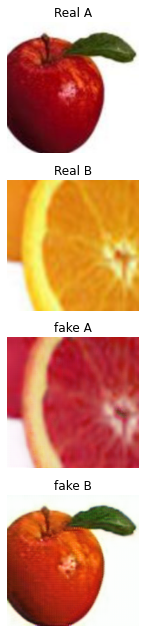

epoch: 100%|██████████| 50/50 [7:00:23<00:00, 504.46s/it]


In [23]:
history = train(generator_AtoB, generator_BtoA, discriminator_A, discriminator_B, optimizer_G, \
                optimizer_D_A, optimizer_D_B, train_dataset, num_epochs, batch_size)

In [0]:
with open('/content/history.txt', 'w') as f:
  for elem in history:
    f.write(str(elem))

In [0]:
test_dataset = ModelDataset('/content/apple2orange', mode='test', augmentation=augmentation_train)

In [0]:
def test(te_dataset, model_A, model_B):
  
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

  data = next(iter(test_loader))
    
  plt.figure(figsize=(18, 6))

  ax1 = plt.subplot(1, 4, 1)
  ax1.set_title('Fake orange')
  plt.axis("off")
  fake_B = model_A(data['A'].to(DEVICE))
  imshow(fake_B[0].data.cpu())

  ax3 = plt.subplot(1, 4, 2)
  ax3.set_title('Real apple')
  plt.axis("off")
  imshow(data['A'][0].data)

  ax2 = plt.subplot(1, 4, 3)
  random2 = int(np.random.uniform(0, te_dataset.len_B()))
  plt.axis("off")
  ax2.set_title('fake apple')
  fake_A = model_B(data['B'].to(DEVICE))
  imshow(fake_A[0].data.cpu())

  ax4 = plt.subplot(1, 4, 4)
  ax4.set_title('Real orange')
  plt.axis("off")
  imshow(data['B'][0].data)


  plt.show()

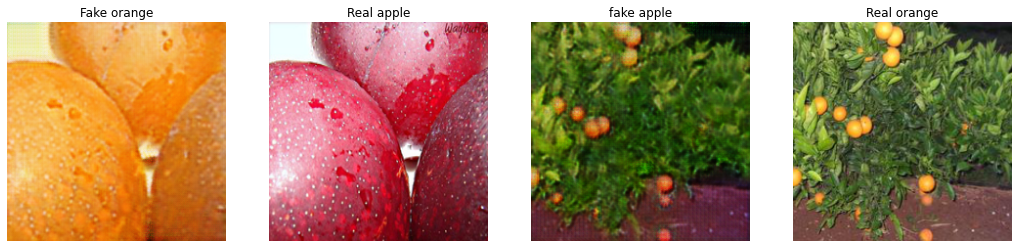

In [59]:
test(test_dataset, generator_AtoB, generator_BtoA)

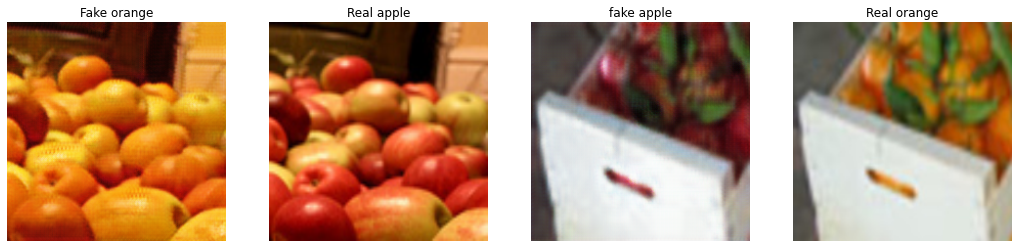

In [77]:
test(test_dataset, generator_AtoB, generator_BtoA)

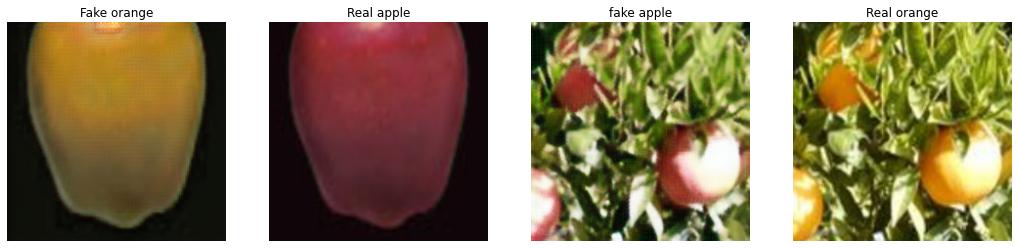

In [78]:
test(test_dataset, generator_AtoB, generator_BtoA)

Все скачки на графиках на 40 эпохе обусловлены снижением learning rate

In [0]:
loss_identity = []

loss_G_GAN = []

loss_G_cycle = []

loss_D = []

full_loss = []

for i in range(len(history)):
    loss_identity.append(history[i][0])
    loss_G_GAN.append(history[i][1])
    loss_G_cycle.append(history[i][2])
    loss_D.append(history[i][3])
    full_loss.append(history[i][4])

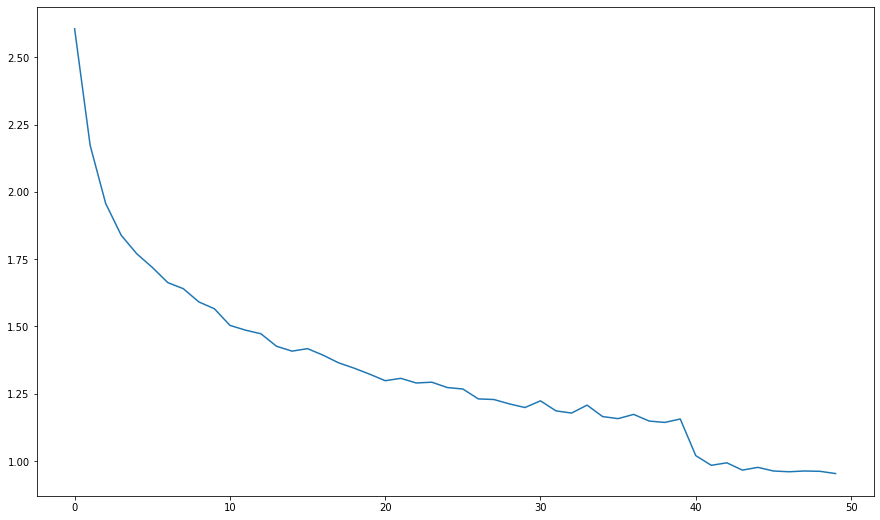

In [38]:
plt.figure(figsize=(15, 9))
plt.plot(loss_identity)
plt.show()

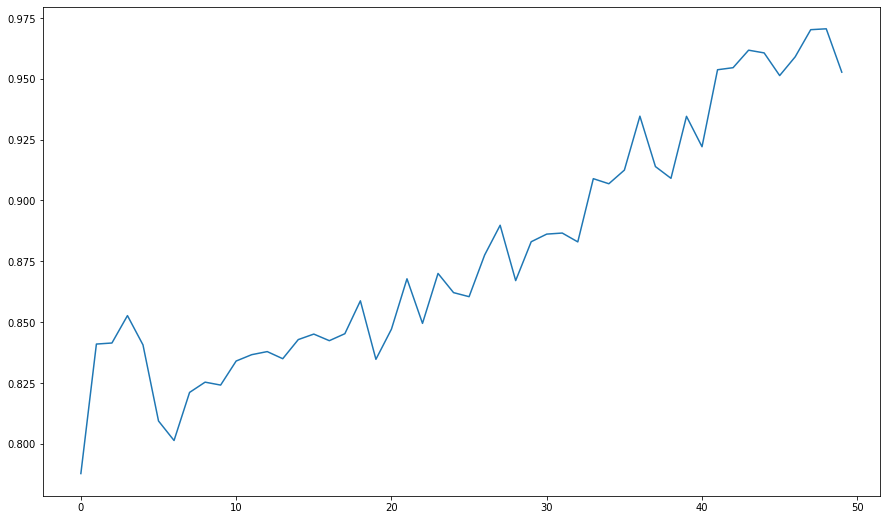

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss_G_GAN)
plt.show()

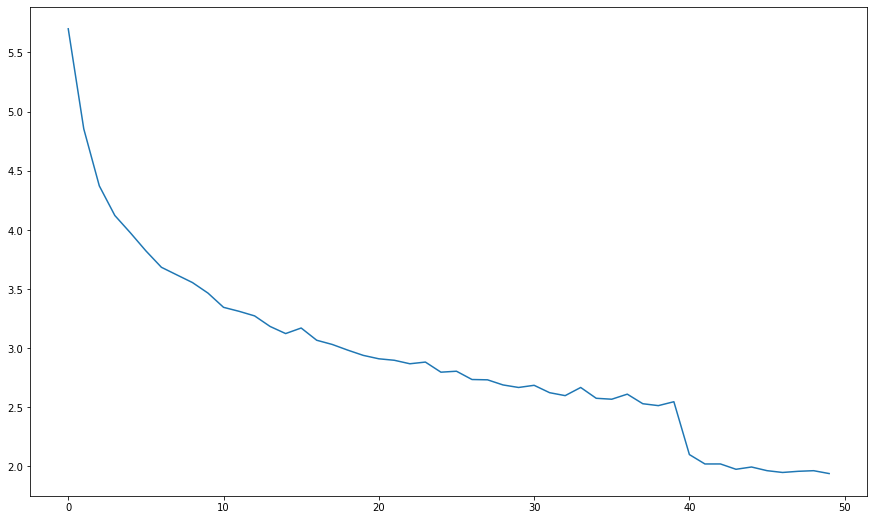

In [40]:
plt.figure(figsize=(15, 9))
plt.plot(loss_G_cycle)
plt.show()

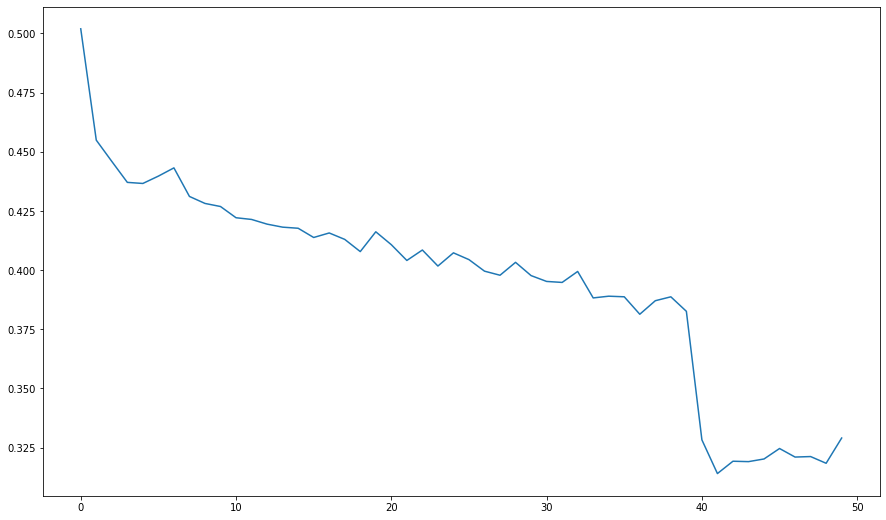

In [41]:
plt.figure(figsize=(15, 9))
plt.plot(loss_D)
plt.show()

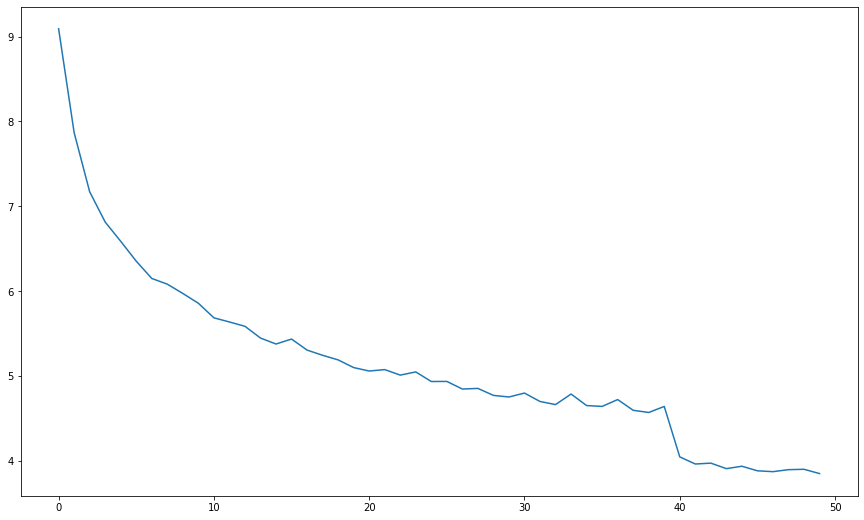

In [42]:
plt.figure(figsize=(15, 9))
plt.plot(full_loss)
plt.show()

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)